---
title: "Stock EDA"
format:
  html:
    toc: true
    number-sections: false

execute:
  echo: true
  warning: false
  cache: false

jupyter: python3
params:
  symbol: "AAPL"
  start_date: "2018-01-01"
  end_date: ""
  rolling: 20
---

> *Educational use only — not trading advice.* Data pulled via **yfinance** [@yfinance].

This page is **parameterized**; see the **Parameters** section for usage.

## Setup parameters if using Python

In [1]:
# Default values (overridden by -P at render time)
SYMBOL = "AAPL"
START  = "2018-01-01"
END    = ""
ROLL   =  20

## Setup

In [2]:
#| echo: true
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path

# SYMBOL = params.get("symbol", "AAPL")
# START  = params.get("start_date", "2018-01-01")
# END    = params.get("end_date", "")
# ROLL   = int(params.get("rolling", 20))
if not END:
  END = pd.Timestamp.today().strftime("%Y-%m-%d")

## Download and tidy

In [3]:
#| echo: true
try:
  data = yf.download(SYMBOL, start=START, end=END, auto_adjust=True, progress=False)
except Exception as e:
  # Synthetic fallback
  idx = pd.bdate_range(START, END)
  rng = np.random.default_rng(42)
  ret = rng.normal(0, 0.01, len(idx))
  price = 100 * np.exp(np.cumsum(ret))
  vol = rng.integers(1e5, 5e6, len(idx))
  data = pd.DataFrame({"Close": price, "Volume": vol}, index=idx)

df = (data.rename(columns=str.lower)[["close","volume"]]
        .dropna()
        .assign(log_return=lambda d: np.log(d["close"]).diff()))
df["roll_mean"] = df["log_return"].rolling(ROLL, min_periods=ROLL//2).mean()
df["roll_vol"]  = df["log_return"].rolling(ROLL, min_periods=ROLL//2).std()
df = df.dropna()

## Price over time

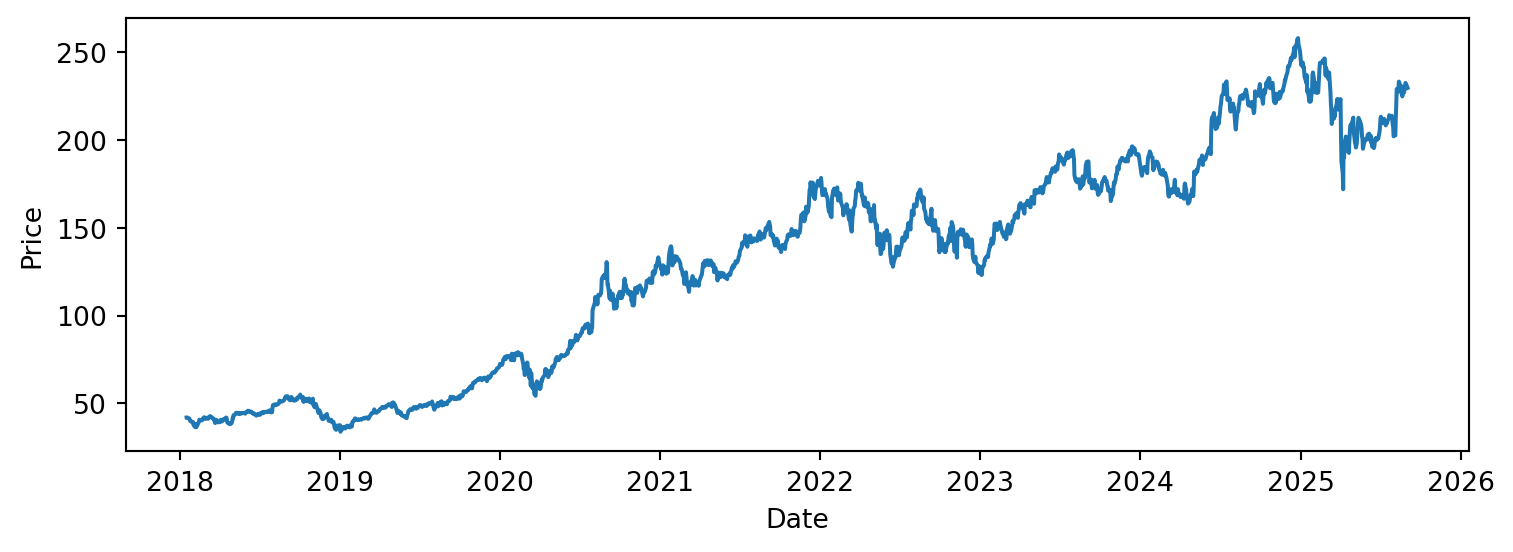

In [4]:
#| label: fig-price
#| fig-cap: '{SYMBOL} — Adjusted Close'
#| fig-alt: Line chart showing adjusted close price of the selected stock over time.
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["close"])
ax.set_xlabel("Date"); ax.set_ylabel("Price")
fig.tight_layout()

As shown in **Figure @fig-price**, prices vary over time with changing volatility.

## Return distribution

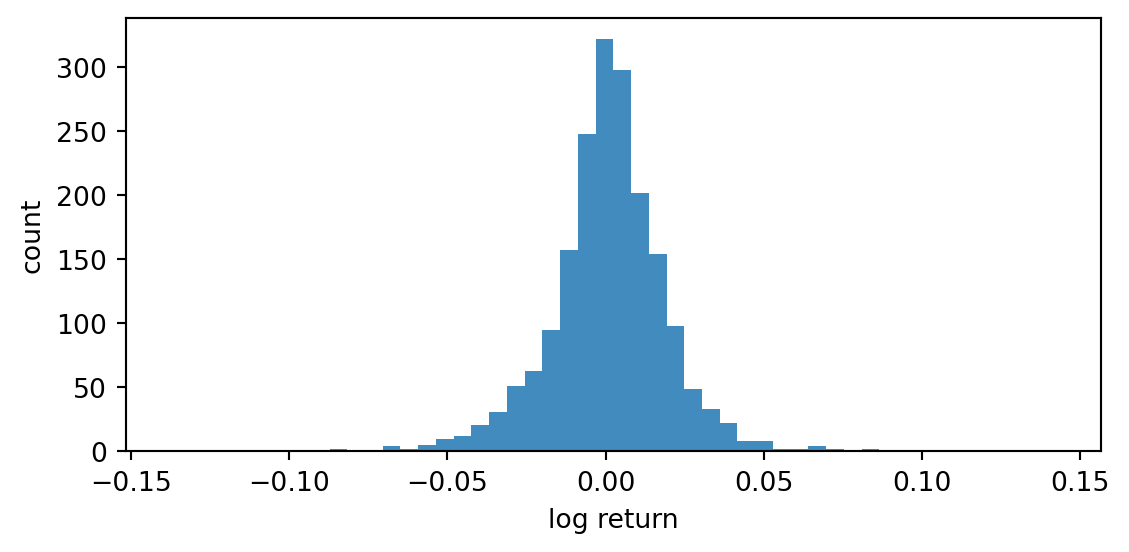

In [5]:
#| label: fig-hist
#| fig-cap: '{SYMBOL} — Daily log return histogram'
#| fig-alt: Histogram of daily log returns.
#| echo: false
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df["log_return"], bins=50, alpha=0.85)
ax.set_xlabel("log return"); ax.set_ylabel("count")
fig.tight_layout()

**Figure @fig-hist** shows the return distribution; many assets exhibit heavy tails \[@hyndman-fpp3, pp. 20–21].

## Rolling statistics (window = {params.rolling})

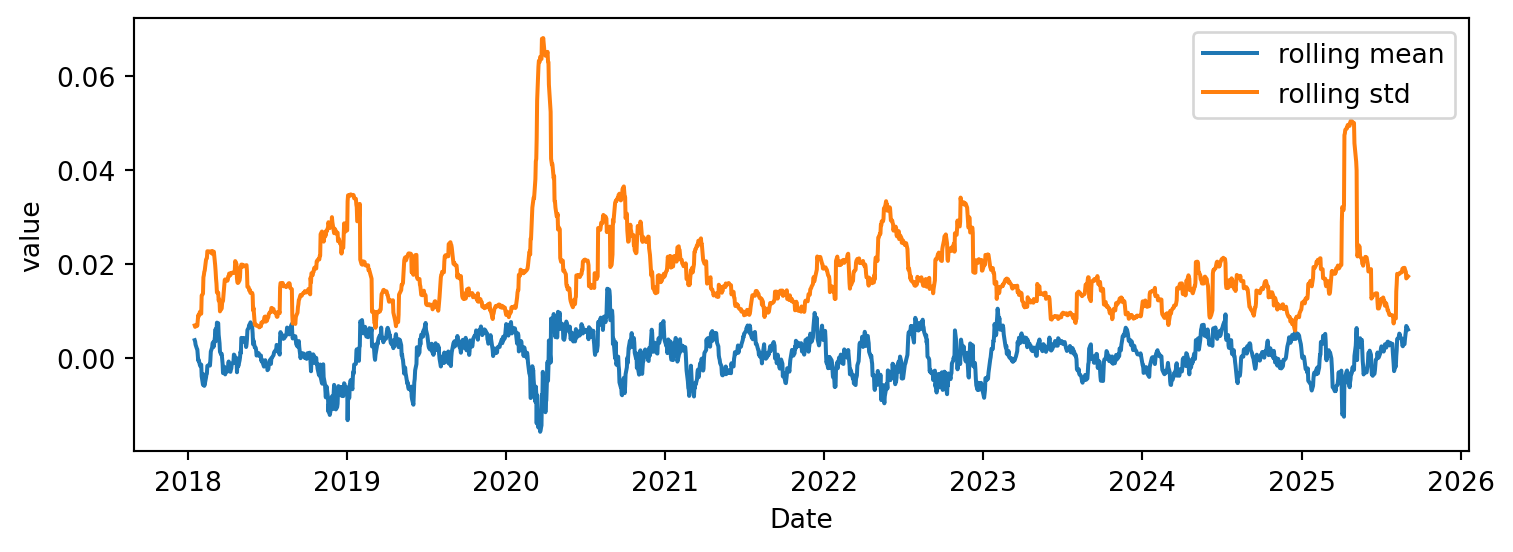

In [6]:
#| label: fig-rolling
#| fig-cap: '{SYMBOL} — Rolling mean and volatility'
#| fig-alt: Two line plots of rolling mean and rolling standard deviation of returns.
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["roll_mean"], label="rolling mean")
ax.plot(df.index, df["roll_vol"],  label="rolling std")
ax.set_xlabel("Date"); ax.set_ylabel("value")
ax.legend()
fig.tight_layout()

## Summary table

In [7]:
#| label: tbl-summary
#| tbl-cap: Summary statistics for {SYMBOL}.
#| echo: false
summary = pd.DataFrame({
    "n_days": [len(df)],
    "start": [df.index.min().date()],
    "end":   [df.index.max().date()],
    "mean_daily_ret": [df["log_return"].mean()],
    "std_daily_ret":  [df["log_return"].std()],
    "ann_vol_approx": [df["log_return"].std()*np.sqrt(252)]
})
summary

,n_days,start,end,mean_daily_ret,std_daily_ret,ann_vol_approx
0,1917,2018-01-17,2025-09-02,0.000895,0.01965,0.311934


See **Table @tbl-summary** for overall statistics.

## Data dictionary

In [8]:
#| label: tbl-dict
#| tbl-cap: Data dictionary for computed columns.
#| echo: false
desc = {
  "close": "Adjusted closing price.",
  "volume": "Trading volume.",
  "log_return": "log(Close_t) − log(Close_{t−1}).",
  "roll_mean": f"Rolling mean of log returns (window={ROLL}).",
  "roll_vol": f"Rolling std of log returns (window={ROLL})."
}
# Build a mapping: first-level name -> combined dtype(s)
dtype_by_price = (
    df.dtypes                          # Series indexed by (Price, Ticker)
      .groupby(level=0)                # group by first level "Price"
      .apply(lambda s: " / ".join(sorted({str(dt) for dt in s})))
)

dd = pd.DataFrame({
    "column": list(desc.keys()),
    "dtype": [dtype_by_price.get(c, "MISSING") for c in desc.keys()],
    "description": list(desc.values())
})
dd
# dd = pd.DataFrame({ 
#   "column": list(desc.keys()), 
#   "dtype": [str(df[c].dtype) for c in desc.keys()], 
#   "description": list(desc.values()) }) 
# dd

,column,dtype,description
0,close,float64,Adjusted closing price.
1,volume,int64,Trading volume.
2,log_return,float64,log(Close_t) − log(Close_{t−1}).
3,roll_mean,float64,Rolling mean of log returns (window=20).
4,roll_vol,float64,Rolling std of log returns (window=20).


## Parameters

This page accepts parameters: `symbol`, `start_date`, `end_date`, and `rolling`. You can re‑render with:

```
quarto render reports/eda.qmd \\
  -P symbol:MSFT -P start_date:2019-01-01 -P end_date:2025-08-01 -P rolling:30
```

## References
